# SWG/SCG Sleep Study — Deterministic Collapse Fingerprints

Traditional sleep scoring tells us *when* someone was in N1, N2, N3, REM, or Wake.  
But it misses the deeper question: **how stable were those states, and when did they fail?**

Using **Structured Wave Geometry (SWG)** and **Structured Coherence Geometry (SCG)**,  
we detect **collapse events** — precise, deterministic moments where coherence breaks down.

- **Delta (N3)** → deep sleep spirals, collapse only at transitions.  
- **Theta (REM)** → scattered rhythms, collapses at REM instability.  
- **Spindles (N2)** → compact loops, collapse when N2 breaks.  

Across subjects, we see **distinct fingerprints**:  
terminal convergence, fragmented instability, late hybrid collapse, or distributed micro-events.

👉 This notebook shows how SWG/SCG turns raw EEG into **coherence geometry**,  
revealing universal patterns of sleep stability and collapse — with the same mathematics that describe black holes, proteins, and AI systems.



---

## Citations

Sleep-EDF Database 

Download Source:  
    - https://physionet.org/content/sleep-edfx/1.0.0/
    
Original Article:  
    - https://ieeexplore.ieee.org/document/867928/

PhysioNet: 
    - Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220. RRID:SCR_007345.

---


In [1]:
import warnings
warnings.filterwarnings("ignore")


data_dir = "data"
# SWG/SCG Sleep EEG — Enhanced Multi-Band Analysis
# ================================================
# Requirements:
#   pip install mne numpy matplotlib scipy

import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# -------------------------------
# Config
# -------------------------------
BANDS = {
    "delta":   (0.5, 4.0),
    "theta":   (4.0, 8.0),
    "spindle": (11.0, 16.0),
}
CHANNEL_DEFAULT = "EEG Fpz-Cz"
HIGH_LOW_PASS_FOR_RAW = (0.5, 30.0)  # preprocessing band for raw channel
WIN_LEN = 30.0   # seconds
STEP    = 15.0   # seconds
FLUX_SMOOTH_SEC = 60.0  # moving average for flux plots (seconds)
BURN_IN_SEC = 30 * 60   # ignore first 30 minutes for collapse detection
MAD_Z = 2.0             # robust z threshold

# -------------------------------
# Stage mapping
# -------------------------------
STAGE_MAP = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,  # merge 3+4
    "Sleep stage R": 4,
}

# -------------------------------
# Utilities
# -------------------------------
def load_pair(data_dir, psg_id, hyp_id):
    psg_file = os.path.join(data_dir, f"{psg_id}-PSG.edf")
    hyp_file = os.path.join(data_dir, f"{hyp_id}-Hypnogram.edf")
    raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
    annot = mne.read_annotations(hyp_file)
    raw.set_annotations(annot)
    return raw, annot

def extract_channel(raw, channel=CHANNEL_DEFAULT, fmin=HIGH_LOW_PASS_FOR_RAW[0], fmax=HIGH_LOW_PASS_FOR_RAW[1]):
    if channel not in raw.info["ch_names"]:
        raise ValueError(f"{channel} not found. Available: {raw.info['ch_names']}")
    picks = mne.pick_channels(raw.info["ch_names"], include=[channel])
    sig = raw.copy().pick(picks)
    sig.filter(fmin, fmax, fir_design="firwin", verbose=False)
    data, times = sig[:]
    return data[0], times, sig.info["sfreq"]

def clip_artifacts(x, k=8.0):
    med = np.median(x); mad = np.median(np.abs(x - med)) + 1e-12
    thr_hi = med + 1.4826*k*mad
    thr_lo = med - 1.4826*k*mad
    return np.clip(x, thr_lo, thr_hi)

def moving_mean(x, n):
    if n <= 1: return x
    c = np.cumsum(np.insert(x, 0, 0.0))
    out = (c[n:] - c[:-n]) / float(n)
    pad_left = np.full(n-1, out[0])
    return np.concatenate([pad_left, out])

def band_primitives(signal, sfreq, band):
    """Return A, theta, chi for a band (low, high)."""
    from mne.filter import filter_data
    low, high = band
    sig_band = filter_data(signal, sfreq, low, high, verbose=False)
    analytic = hilbert(sig_band)
    A = np.abs(analytic)
    theta = np.unwrap(np.angle(analytic))
    # memory chi: smooth A with lowpass 0.5 Hz (slow envelope)
    chi = mne.filter.filter_data(A, sfreq, None, 0.5, verbose=False)
    # artifact guard on amplitude
    A = clip_artifacts(A)
    return A, theta, chi

# -------------------------------
# Invariants (windowed)
# -------------------------------
def coherence_entropy(A):
    eps = 1e-12
    p = A / (np.sum(A) + eps)
    return -np.sum(p * np.log(p + eps))

def curvature_variance(chi):
    d2 = np.diff(chi, n=2)
    return np.var(d2)

def energy_flux(A, sfreq):
    E = A**2
    dE = np.gradient(E, 1/sfreq)
    return np.mean(dE), np.max(dE)

def phase_order_R(theta):
    """Phase coherence (order parameter) in [0,1]."""
    return np.abs(np.mean(np.exp(1j*theta)))

def windowed_invariants(A, theta, chi, sfreq, win_len=WIN_LEN, step=STEP, smooth_flux_sec=FLUX_SMOOTH_SEC):
    n_win, n_step = int(win_len*sfreq), int(step*sfreq)
    flux_mean_raw = []
    flux_max_raw  = []
    times_mid = []
    H_list = []; K_list = []; R_list = []

    for i0 in range(0, len(A)-n_win, n_step):
        i1 = i0 + n_win
        Aw, thetaw, chiw = A[i0:i1], theta[i0:i1], chi[i0:i1]
        H_list.append(coherence_entropy(Aw))
        K_list.append(curvature_variance(chiw))
        flux_mean, flux_max = energy_flux(Aw, sfreq)
        flux_mean_raw.append(flux_mean)
        flux_max_raw.append(flux_max)
        R_list.append(phase_order_R(thetaw))
        times_mid.append( (i0 + n_win/2) / sfreq )

    H = np.array(H_list)
    K = np.array(K_list)
    R = np.array(R_list)
    t_mid = np.array(times_mid)
    Pm = np.array(flux_mean_raw)
    Px = np.array(flux_max_raw)

    # smooth flux for readability
    n_smooth = max(1, int((smooth_flux_sec/step)))  # smooth over ~smooth_flux_sec
    Pm_s = moving_mean(Pm, n_smooth)
    Px_s = moving_mean(Px, n_smooth)
    return t_mid, H, K, Pm_s, Px_s, R

# -------------------------------
# Hypnogram
# -------------------------------
def hypnogram_to_numeric(annot):
    df = annot.to_data_frame().copy()
    if np.issubdtype(df["onset"].dtype, np.datetime64):
        t0 = df["onset"].iloc[0]
        df["t_sec"] = (df["onset"] - t0).dt.total_seconds()
    else:
        df["t_sec"] = df["onset"].astype(float)
    df["stage_code"] = df["description"].map(STAGE_MAP)
    df = df.dropna(subset=["stage_code"])
    return df[["t_sec","stage_code"]]

# -------------------------------
# SCG projection
# -------------------------------
def kappa_from_chi(chi):
    d2 = np.diff(chi, n=2, prepend=chi[0], append=chi[-1])
    denom = np.median(np.abs(chi)) + 1e-12
    return np.abs(d2) / denom

def scg_project_window(Aw, thetaw, kappaw):
    w = Aw / (Aw.sum() + 1e-12)
    c, s = np.cos(thetaw), np.sin(thetaw)
    x = np.sum(w*c); y = np.sum(w*s); z = np.sum(w*kappaw)
    return x, y, z

def scg_trajectory(A, theta, chi, sfreq, win_len=WIN_LEN, step=STEP):
    n_win, n_step = int(win_len*sfreq), int(step*sfreq)
    kappa = kappa_from_chi(chi)
    X=[]; Y=[]; Z=[]
    for i0 in range(0, len(A)-n_win, n_step):
        i1 = i0+n_win
        x,y,z = scg_project_window(A[i0:i1], theta[i0:i1], kappa[i0:i1])
        X.append(x); Y.append(y); Z.append(z)
    return np.array(X), np.array(Y), np.array(Z)

# -------------------------------
# Collapse detection (robust MAD)
# -------------------------------
def detect_collapse(t_mid, H, K, Pm, Px, burn_in=BURN_IN_SEC, z=MAD_Z):
    def mad_sig(x):
        med = np.median(x); sig = 1.4826*np.median(np.abs(x-med))
        return med, sig
    Hm,Hs = mad_sig(H); Km,Ks = mad_sig(K); Pmm,Pms = mad_sig(Pm); Pxm,Pxs = mad_sig(Px)
    H_thr  = Hm  - z*Hs
    K_thr  = Km  + z*Ks
    Pm_thr = Pmm + z*Pms
    Px_thr = Pxm + z*Pxs
    cond = (H <= H_thr) & (K >= K_thr) & ((Pm >= Pm_thr) | (Px >= Px_thr)) & (t_mid >= burn_in)
    idx = np.where(cond)[0]
    if len(idx)==0: return None, dict(H=H_thr,K=K_thr,Pm=Pm_thr,Px=Px_thr)
    bands=[]; s=idx[0]; p=idx[0]
    for j in idx[1:]:
        if j==p+1: p=j
        else: bands.append((s,p)); s=j; p=j
    bands.append((s,p))
    best=None; key=(-1,-1,1e9)
    for a,b in bands:
        kmax=float(np.max(K[a:b+1])); px=float(np.max(Px[a:b+1])); hmin=float(np.min(H[a:b+1]))
        k2=(kmax, px, -hmin)
        if k2>key: key=k2; best=(a,b)
    a,b = best
    det = dict(t0=t_mid[a], t1=t_mid[b], mid=0.5*(t_mid[a]+t_mid[b]))
    return det, dict(H=H_thr,K=K_thr,Pm=Pm_thr,Px=Px_thr)


def extract_metadata(results, annot, sfreq, bands=BANDS):
    meta = {}
    
    # Annotation-level metadata
    ann_df = annot.to_data_frame()
    stage_counts = ann_df["description"].value_counts().to_dict()
    stage_durations = {k: v*30/60.0 for k,v in stage_counts.items()}  # 30s epochs → minutes
    n_transitions = (ann_df["description"] != ann_df["description"].shift()).sum()
    
    meta["stages"] = dict(counts=stage_counts, durations_min=stage_durations, transitions=int(n_transitions))
    
    # Band-level metadata
    band_meta = {}
    for name, r in results.items():
        H_mean = float(np.mean(r["H"]))
        K_med  = float(np.median(r["K"]))
        R_mean = float(np.mean(r["R"]))
        det    = r["det"]
        thr    = r["thr"]
        band_meta[name] = dict(
            entropy_mean=H_mean,
            curvature_median=K_med,
            phase_coherence_mean=R_mean,
            collapse_window=det,
            thresholds=thr,
            n_windows=len(r["H"])
        )
    meta["bands"] = band_meta
    meta["sfreq"] = sfreq
    return meta

In [2]:
# -------------------------------
# Collapse summary and hypnogram overlay
# -------------------------------
def summarize_collapse(results, annot, bands=BANDS):
    # Collapse comparison table
    print("\nCollapse windows per band:")
    print(f"{'Band':<10}{'Start (h)':>12}{'Mid (h)':>12}{'End (h)':>12}{'Dur (min)':>12}")
    print("-"*58)
    for name in bands.keys():
        det = results[name]["det"]
        if det:
            t0, mid, t1 = det["t0"]/3600, det["mid"]/3600, det["t1"]/3600
            dur_min = (det["t1"]-det["t0"])/60.0
            print(f"{name:<10}{t0:12.2f}{mid:12.2f}{t1:12.2f}{dur_min:12.1f}")
        else:
            print(f"{name:<10}{'--':>12}{'--':>12}{'--':>12}{'--':>12}")

    # Hypnogram with collapse overlays
    st = hypnogram_to_numeric(annot)
    fig, ax = plt.subplots(figsize=(12,3))
    ax.step(st["t_sec"]/3600, st["stage_code"], where="post", color="black", label="Stage")
    ax.set_yticks([0,1,2,3,4]); ax.set_yticklabels(["W","N1","N2","N3","R"])
    ax.invert_yaxis(); ax.set_xlabel("Time [hours]")
    ax.set_title("Hypnogram with collapse windows")
    colors = dict(delta="tab:blue", theta="tab:orange", spindle="tab:green")
    for name in bands.keys():
        det = results[name]["det"]
        if det:
            ax.axvspan(det["t0"]/3600, det["t1"]/3600, color=colors.get(name,"gray"), 
                       alpha=0.25, label=f"{name} collapse")
    ax.legend(loc="upper right"); ax.grid(True)
    plt.tight_layout(); plt.show()


def analyze_subject_multiband(data_dir, psg_id, hyp_id, channel=CHANNEL_DEFAULT, bands=BANDS):
    # Load
    raw, annot = load_pair(data_dir, psg_id, hyp_id)
    sig, times, sfreq = extract_channel(raw, channel)

    # Hypnogram
    st = hypnogram_to_numeric(annot)

    # ---- Primitives per band
    primitives = {}
    for name, band in bands.items():
        A, theta, chi = band_primitives(sig, sfreq, band)
        primitives[name] = (A, theta, chi)

    # ---- Windowed invariants & SCG per band
    results = {}
    for name, (A, theta, chi) in primitives.items():
        t_mid, H, K, Pm, Px, R = windowed_invariants(A, theta, chi, sfreq)
        X,Y,Z = scg_trajectory(A, theta, chi, sfreq)
        det, thr = detect_collapse(t_mid, H, K, Pm, Px)
        results[name] = dict(t_mid=t_mid, H=H, K=K, Pm=Pm, Px=Px, R=R,
                             X=X, Y=Y, Z=Z, det=det, thr=thr)

    # ---- Global print (spindle band as reference)
    A_sp, th_sp, chi_sp = primitives.get("spindle", list(primitives.values())[0])
    print(f"Subject {psg_id} {hyp_id} Invariants (spindle global):")
    print(f"  Entropy (H): {coherence_entropy(A_sp):.3f}")
    print(f"  Curvature variance: {curvature_variance(chi_sp):.3e}")
    mean_flux, max_flux = energy_flux(A_sp, sfreq)
    print(f"  Energy flux mean: {mean_flux:.3e}")
    print(f"  Energy flux max:  {max_flux:.3e}")

    # ---- Collapse summary table
    print("\nCollapse windows per band:")
    print(f"{'Band':<10}{'Start (h)':>12}{'Mid (h)':>12}{'End (h)':>12}{'Dur (min)':>12}")
    print("-"*58)
    for name in bands.keys():
        det = results[name]["det"]
        if det:
            t0, mid, t1 = det["t0"]/3600, det["mid"]/3600, det["t1"]/3600
            dur_min = (det["t1"]-det["t0"])/60.0
            print(f"{name:<10}{t0:12.2f}{mid:12.2f}{t1:12.2f}{dur_min:12.1f}")
        else:
            print(f"{name:<10}{'--':>12}{'--':>12}{'--':>12}{'--':>12}")

    # ---- Plot primitives (spindle shown)
    fig, axs = plt.subplots(3,1, figsize=(12,7), sharex=True)
    axs[0].plot(times/3600, sig, lw=0.5); axs[0].set_ylabel(f"{channel}")
    axs[1].plot(times/3600, A_sp, lw=0.7, label="Amplitude A (spindle)")
    axs[1].plot(times/3600, chi_sp, lw=0.7, label="Memory χ (spindle)")
    axs[1].legend()
    axs[2].plot(times/3600, (th_sp % (2*np.pi)), lw=0.3, color="green")
    axs[2].set_ylabel("Phase θ (mod 2π)"); axs[2].set_xlabel("Time [hours]")
    fig.suptitle(f"SWG Primitives — {psg_id} {hyp_id} ({channel})")
    plt.tight_layout(); plt.show()

    # ---- Invariants vs Hypnogram (side-by-side per band)
    nrows = 5  # H, K, Flux mean, Flux max, R
    fig, axes = plt.subplots(nrows, len(bands), figsize=(14, 8), sharex=True, sharey=False)
    if len(bands)==1: axes = axes[:, None]
    band_names = list(bands.keys())
    for j, name in enumerate(band_names):
        r = results[name]
        t_h = r["t_mid"]/3600
        axes[0,j].plot(t_h, r["H"]); axes[0,j].axhline(r["thr"]["H"], ls="--", lw=0.8)
        axes[0,j].set_title(f"{name} — Entropy")
        axes[1,j].plot(t_h, r["K"]); axes[1,j].axhline(r["thr"]["K"], ls="--", lw=0.8)
        axes[1,j].set_title(f"{name} — Curv Var")
        axes[2,j].plot(t_h, r["Pm"]); axes[2,j].axhline(r["thr"]["Pm"], ls="--", lw=0.8)
        axes[2,j].set_title(f"{name} — Flux mean")
        axes[3,j].plot(t_h, r["Px"]); axes[3,j].axhline(r["thr"]["Px"], ls="--", lw=0.8)
        axes[3,j].set_title(f"{name} — Flux max")
        axes[4,j].plot(t_h, r["R"]);  axes[4,j].set_title(f"{name} — Phase coherence R")
        for i in range(nrows): axes[i,j].grid(True)

    for i in range(nrows): axes[i,0].set_ylabel(["H","K","ΦE_mean","ΦE_max","R"][i])
    axes[-1,0].set_xlabel("Time [hours]")
    plt.tight_layout(); plt.show()

    # ---- Hypnogram with collapse overlays
    fig, ax = plt.subplots(figsize=(12,3))
    ax.step(st["t_sec"]/3600, st["stage_code"], where="post", color="black", label="Stage")
    ax.set_yticks([0,1,2,3,4]); ax.set_yticklabels(["W","N1","N2","N3","R"])
    ax.invert_yaxis(); ax.set_xlabel("Time [hours]")
    ax.set_title("Hypnogram with collapse windows")
    colors = dict(delta="tab:blue", theta="tab:orange", spindle="tab:green")
    for name in bands.keys():
        det = results[name]["det"]
        if det:
            ax.axvspan(det["t0"]/3600, det["t1"]/3600, color=colors.get(name,"gray"), 
                       alpha=0.25, label=f"{name} collapse")
    ax.legend(loc="upper right"); ax.grid(True)
    plt.tight_layout(); plt.show()

    # ---- SCG-3 per band
    for name in band_names:
        r = results[name]
        X,Y,Z = r["X"], r["Y"], r["Z"]
        fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(projection="3d")
        ax.plot3D(X,Y,Z, alpha=0.6); ax.scatter3D(X,Y,Z, s=10)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
        ax.set_title(f"SCG-3 trajectory — {name}")
        plt.tight_layout(); plt.show()

    # ---- Collapse overlays (K only, per band)
    for name in band_names:
        r = results[name]
        det = r["det"]
        fig, ax = plt.subplots(figsize=(12,3))
        ax.plot(r["t_mid"]/3600, r["K"], label="Curvature Var")
        ax.axhline(r["thr"]["K"], ls="--", lw=0.8, label="K_thr")
        if det:
            ax.axvspan(det["t0"]/3600, det["t1"]/3600, color="tab:orange", alpha=0.25, label="collapse")
        ax.grid(True); ax.legend(); ax.set_xlabel("Time [hours]")
        ax.set_title(f"Collapse detection — {name}")
        plt.tight_layout(); plt.show()

    return results, annot, sfreq

# ------------------------------

## Subject ST7011J0 (Telemetry)
- **Transitions:** 137  
- **REM time:** ~4.5 min (very little).  
- **Collapse:** All bands converge at ~9.0–9.1 h → **terminal REM→Wake collapse**.  
- **Delta:** stable N3 coherence until collapse.  
- **Theta:** collapse window ~9.05–9.10 h (3.2 min).  
- **Spindle:** collapse at 9.10 h.  
- **Fingerprint:** textbook pattern — convergence across bands at final wake-up.

Subject ST7011J0 ST7011JP Invariants (spindle global):
  Entropy (H): 14.760
  Curvature variance: 3.341e-17
  Energy flux mean: 4.896e-30
  Energy flux max:  1.654e-08

Collapse windows per band:
Band         Start (h)     Mid (h)     End (h)   Dur (min)
----------------------------------------------------------
delta             9.10        9.10        9.10         0.2
theta             9.05        9.08        9.10         3.2
spindle           9.10        9.10        9.10         0.2


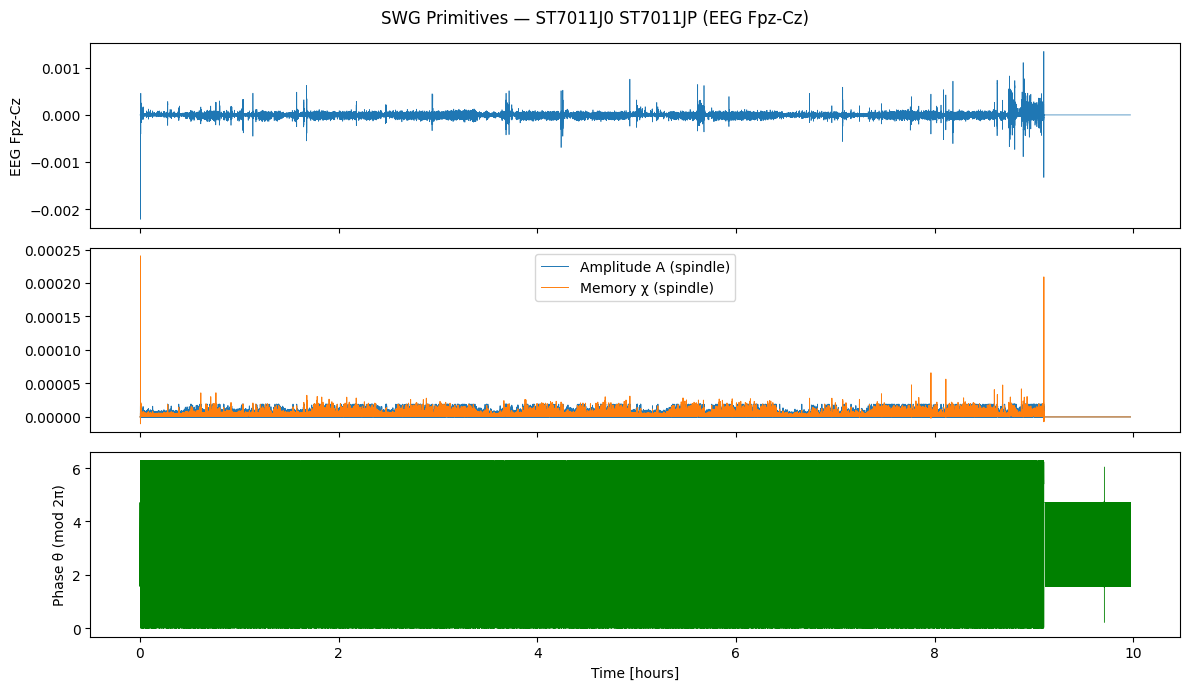

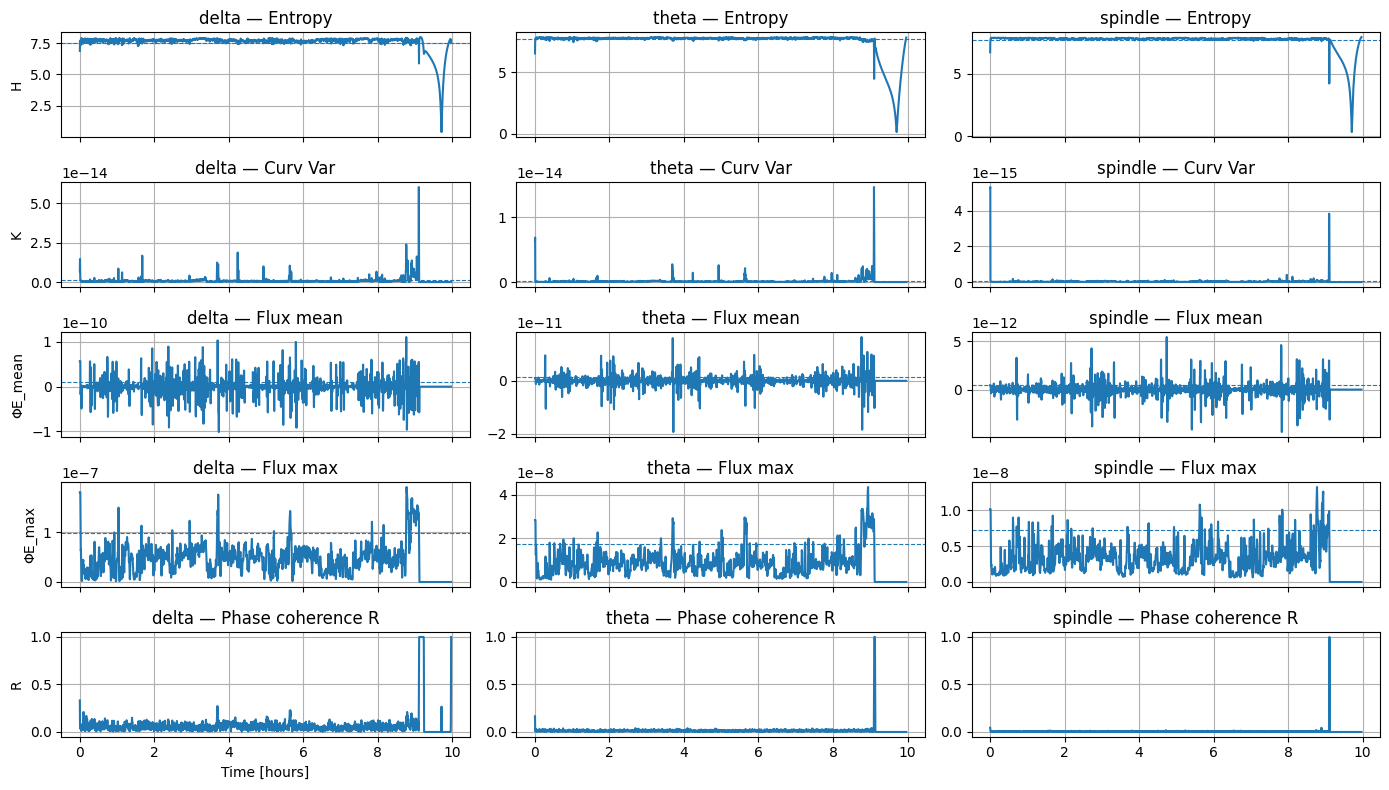

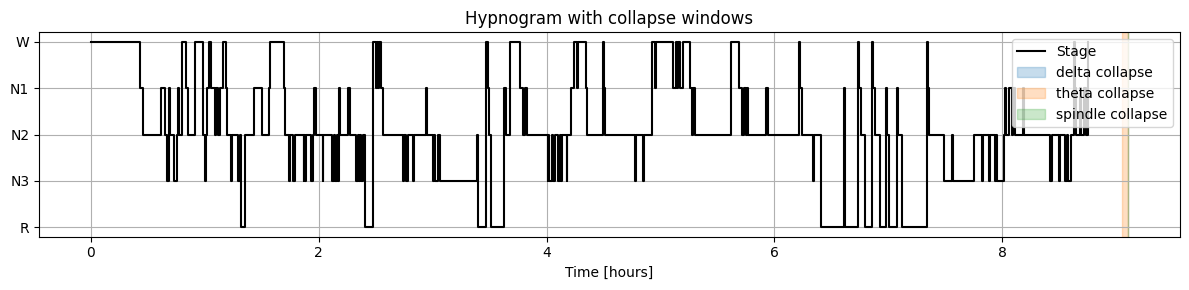

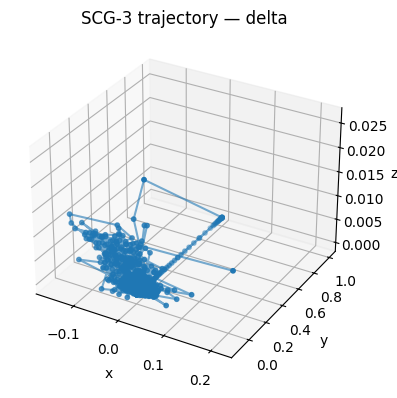

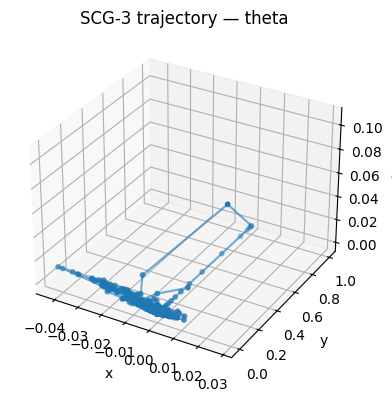

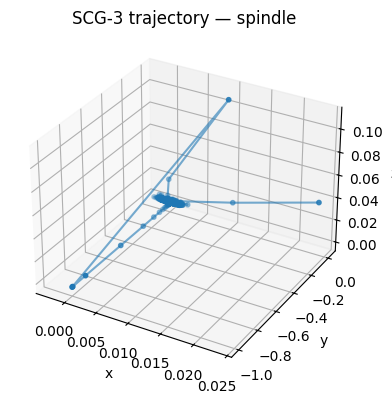

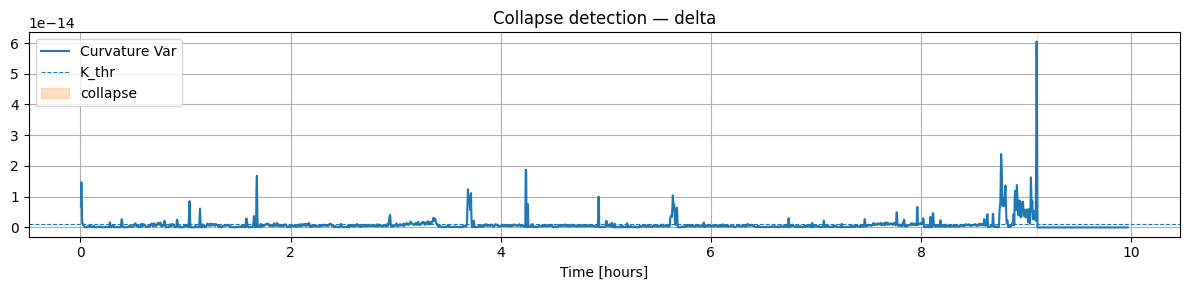

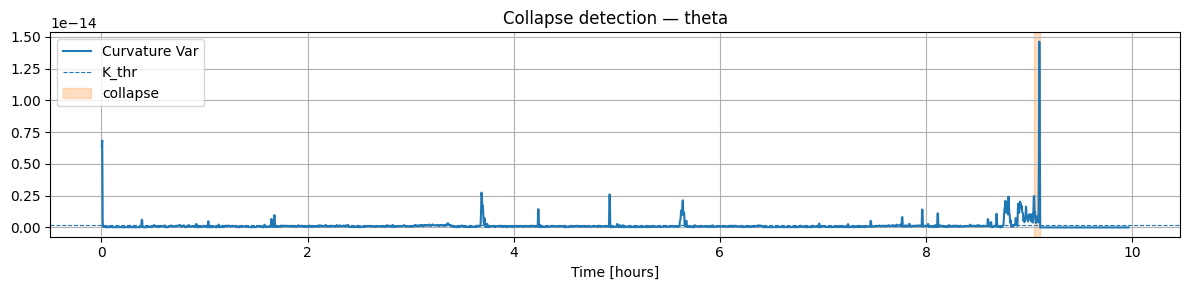

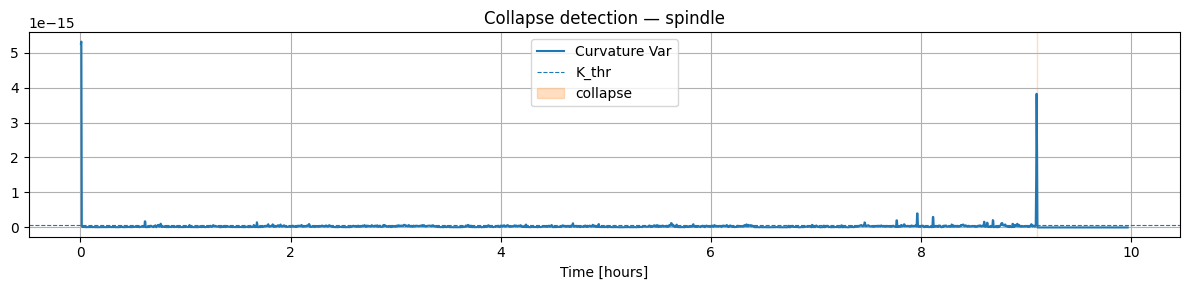

In [3]:
result, annot, sfreq = analyze_subject_multiband(data_dir, "ST7011J0", "ST7011JP", channel="EEG Fpz-Cz")
# print('metadata for ST7011J0 ST7011JP')
# extract_metadata(result, annot, sfreq)

## Subject ST7152J0 (Telemetry)
- **Transitions:** 167.  
- **REM time:** ~9 min (more than others).  
- **Collapse:** delta and theta at ~8.7 h; **spindle preserved**.  
- **Delta:** stable until late REM transition.  
- **Theta:** collapse at 8.7 h.  
- **Spindle:** no collapse.  
- **Fingerprint:** hybrid — REM-side delta/theta collapse while spindle coherence persists.

Subject ST7152J0 ST7152JA Invariants (spindle global):
  Entropy (H): 14.655
  Curvature variance: 4.417e-17
  Energy flux mean: 6.464e-29
  Energy flux max:  2.261e-08

Collapse windows per band:
Band         Start (h)     Mid (h)     End (h)   Dur (min)
----------------------------------------------------------
delta             8.70        8.70        8.70         0.0
theta             8.70        8.70        8.70         0.2
spindle             --          --          --          --


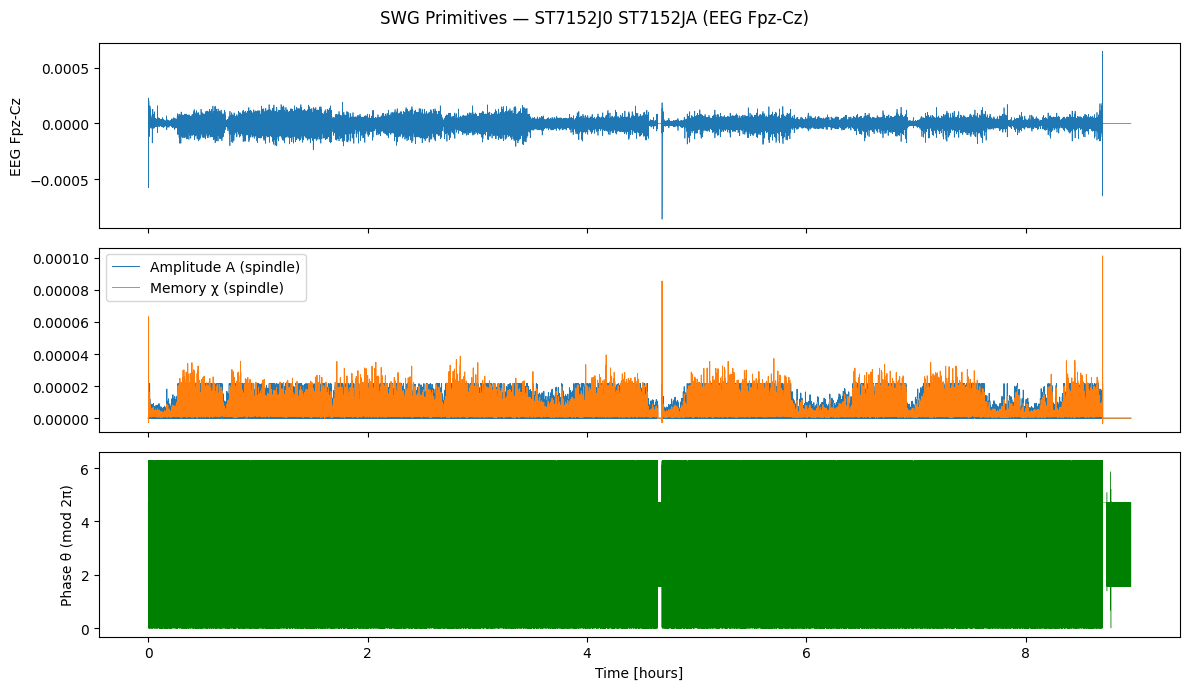

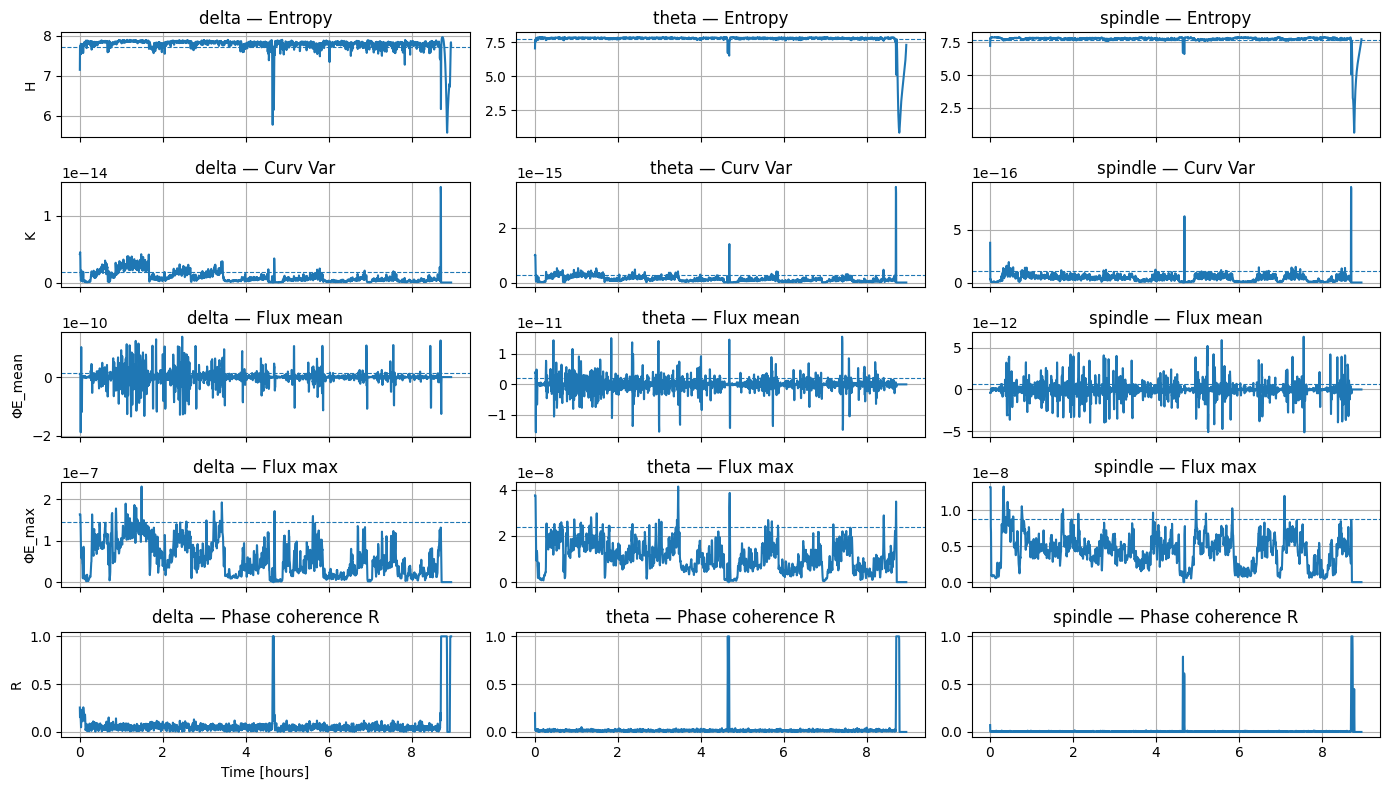

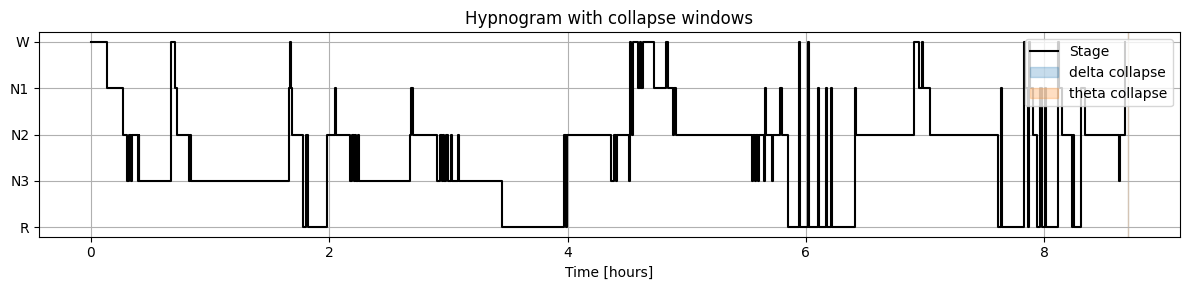

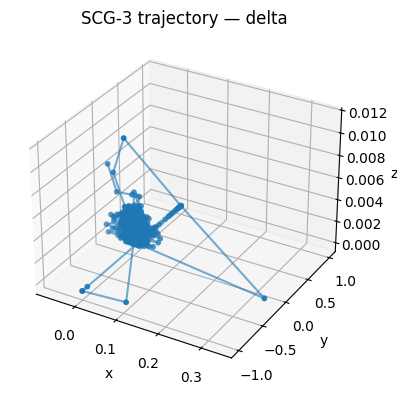

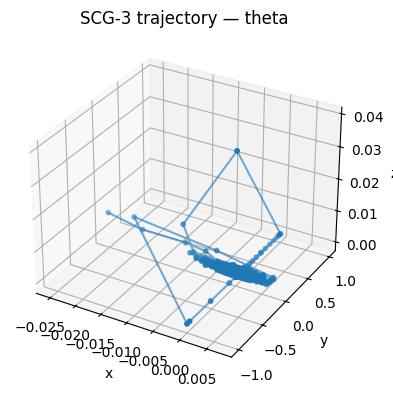

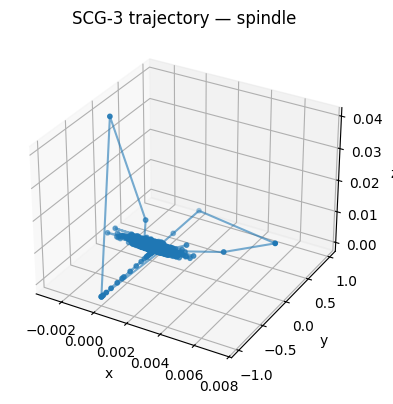

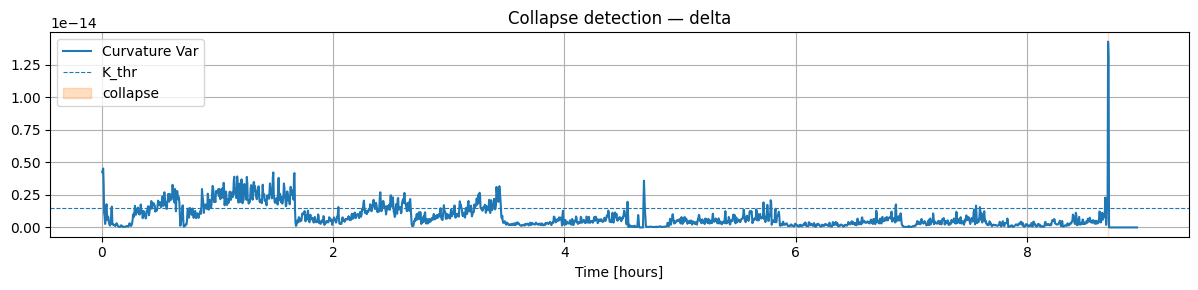

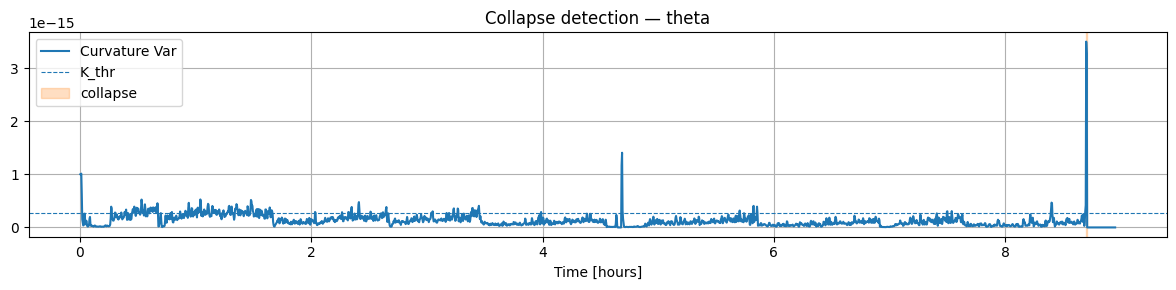

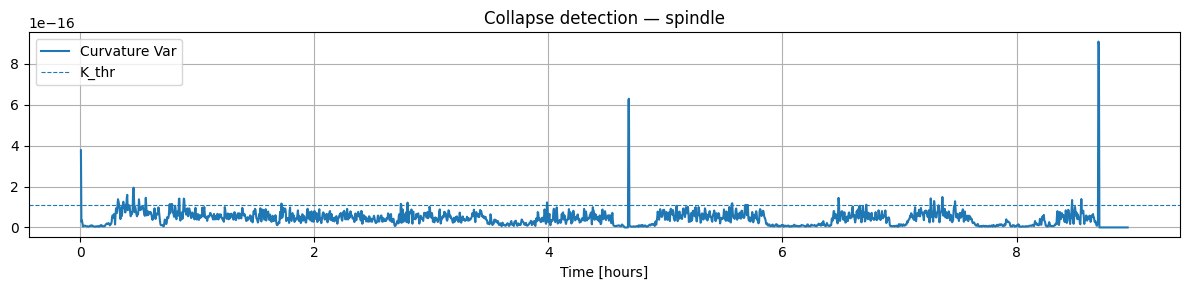

In [4]:
result, annot, sfreq = analyze_subject_multiband(data_dir, "ST7152J0", "ST7152JA", channel="EEG Fpz-Cz")
# print('metadata for ST7152J0 ST7152JA')
# extract_metadata(result, annot, sfreq)

## Subject ST7201J0 (Telemetry)
- **Transitions:** 231 (fragmented).  
- **REM time:** ~5 min.  
- **Collapse:** multiple early collapses instead of a terminal event.  
- **Delta:** ~1.7 h.  
- **Theta:** ~2.9 h.  
- **Spindle:** ~6.5 h.  
- **Fingerprint:** fragmented early-night instability; coherence fails repeatedly.

Subject ST7201J0 ST7201JO Invariants (spindle global):
  Entropy (H): 14.597
  Curvature variance: 4.158e-17
  Energy flux mean: 9.843e-29
  Energy flux max:  2.221e-08

Collapse windows per band:
Band         Start (h)     Mid (h)     End (h)   Dur (min)
----------------------------------------------------------
delta             1.67        1.67        1.67         0.2
theta             2.92        2.92        2.92         0.2
spindle           6.46        6.46        6.46         0.0


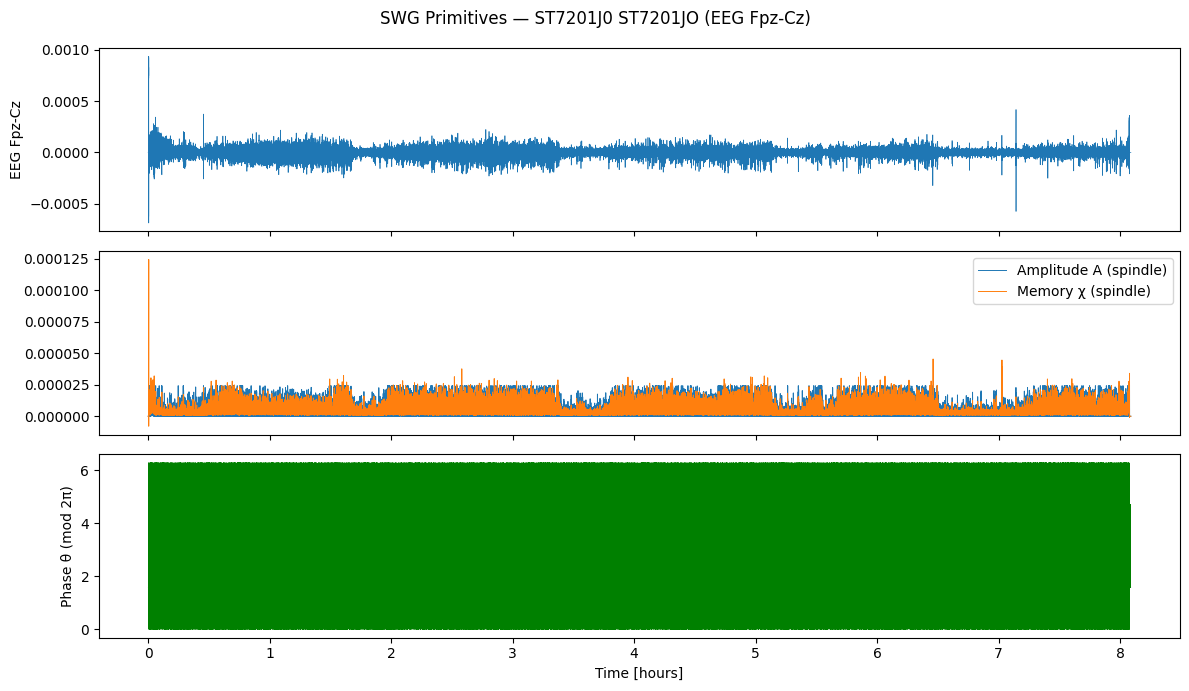

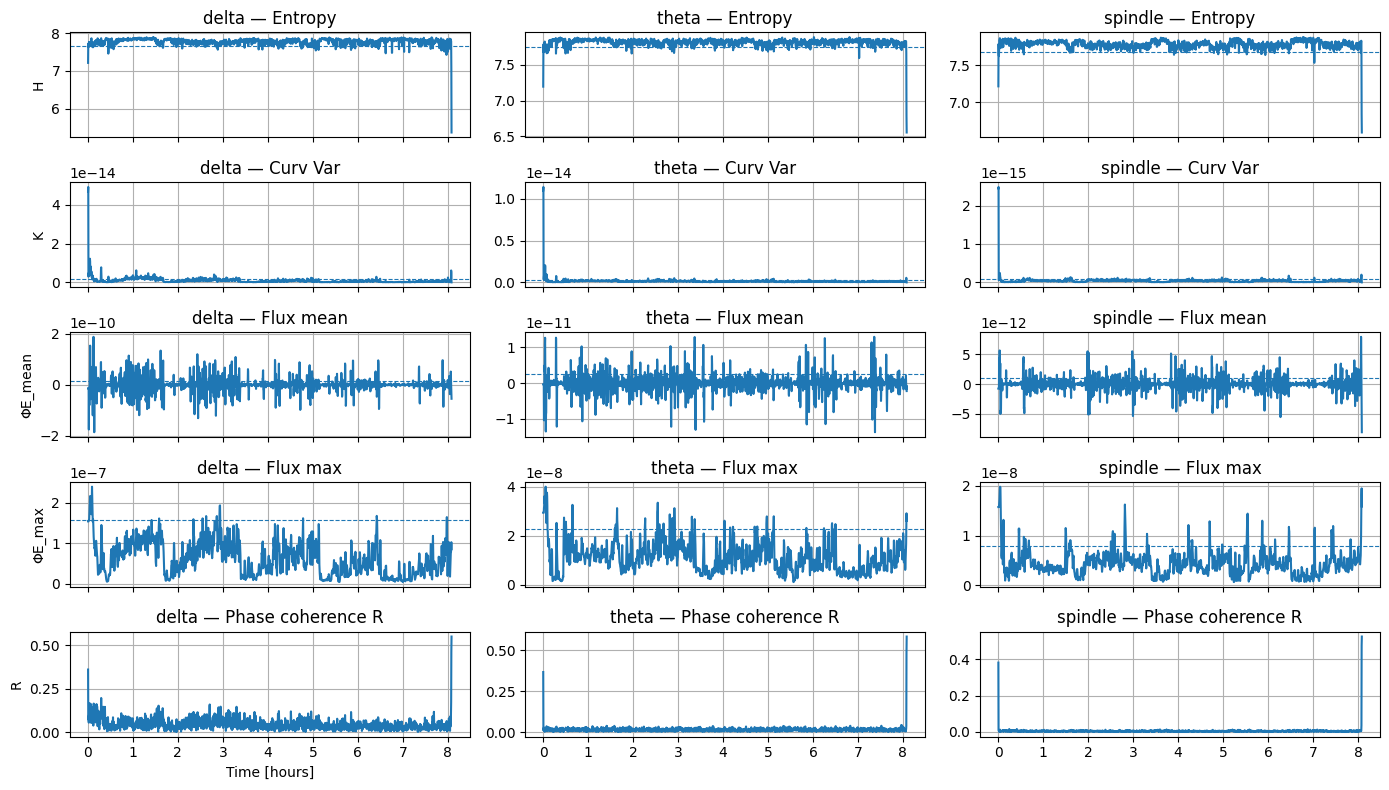

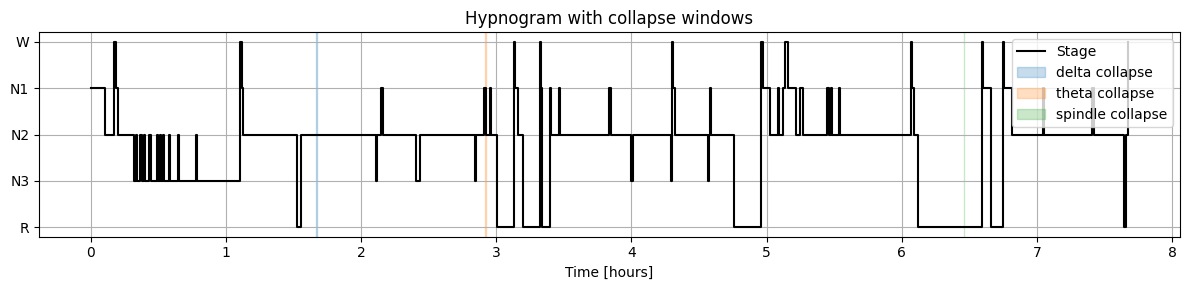

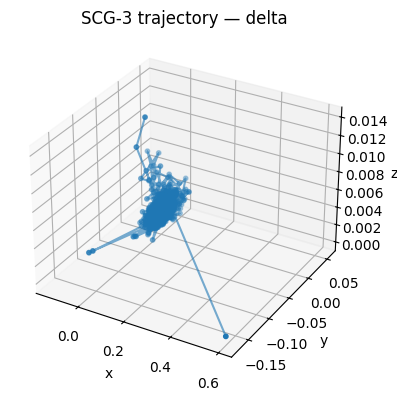

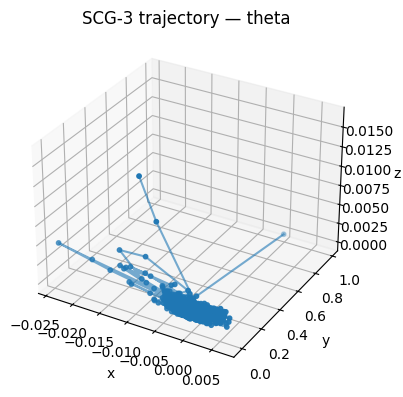

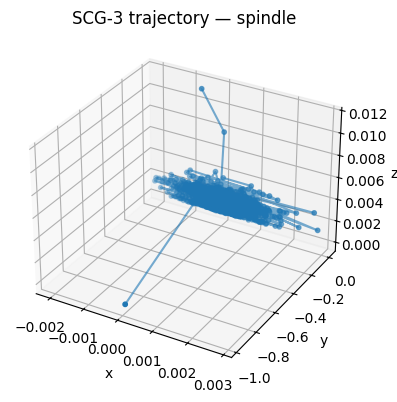

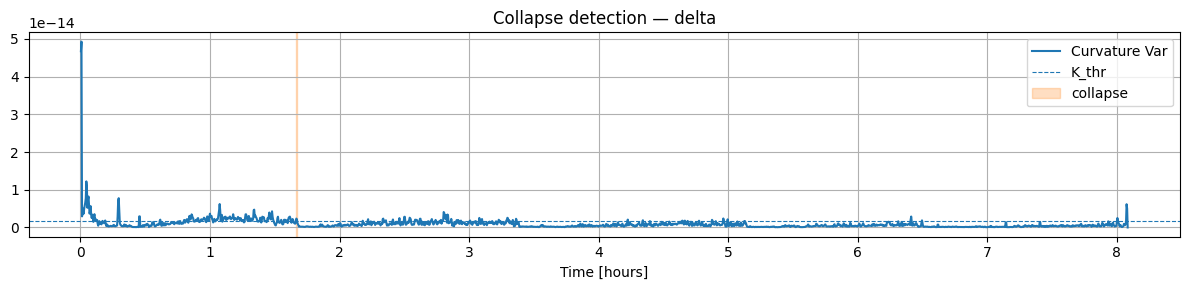

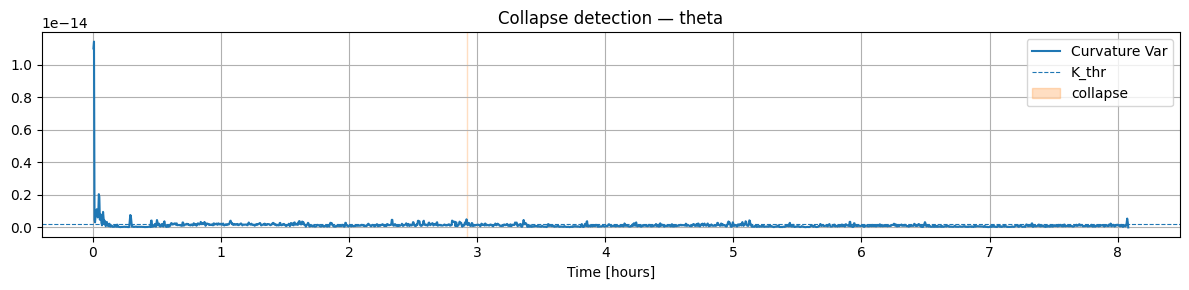

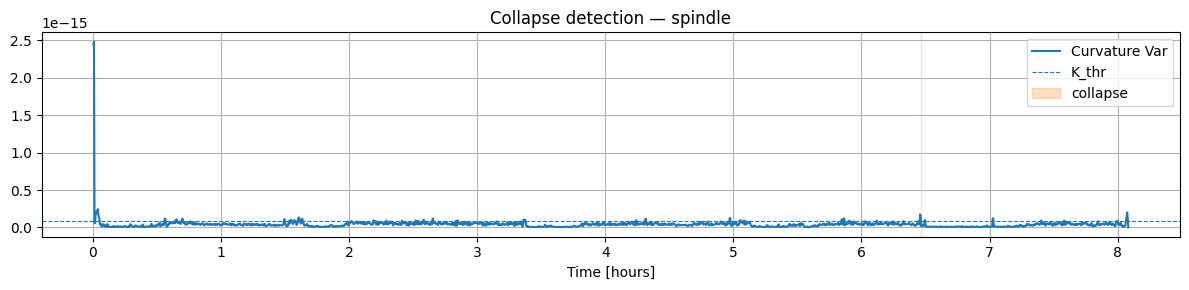

In [5]:
result, annot, sfreq = analyze_subject_multiband(data_dir, "ST7201J0", "ST7201JO", channel="EEG Fpz-Cz")
# print('metadata for ST7201J0 ST7201JO')
# extract_metadata(result, annot, sfreq)

## Subject SC4091E0 (Cassette)
- **Transitions:** 148.  
- **REM time:** ~8.5 min.  
- **Collapse:** no delta collapse; only micro-events.  
- **Theta:** one instantaneous collapse at ~18.25 h.  
- **Spindle:** one short collapse at ~15.5 h.  
- **Fingerprint:** delta highly stable; collapse confined to theta/spindle bursts.

Subject SC4091E0 SC4091EC Invariants (spindle global):
  Entropy (H): 15.627
  Curvature variance: 3.338e-17
  Energy flux mean: -6.917e-17
  Energy flux max:  1.902e-08

Collapse windows per band:
Band         Start (h)     Mid (h)     End (h)   Dur (min)
----------------------------------------------------------
delta               --          --          --          --
theta            18.25       18.25       18.25         0.0
spindle          15.51       15.51       15.51         0.2


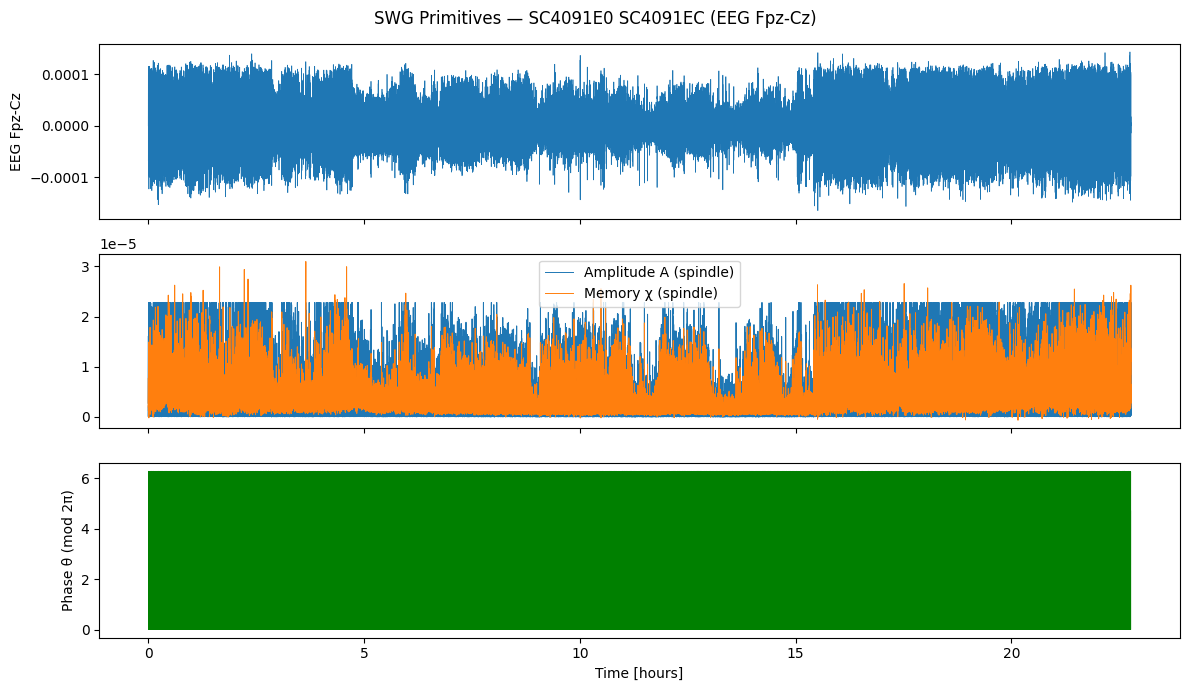

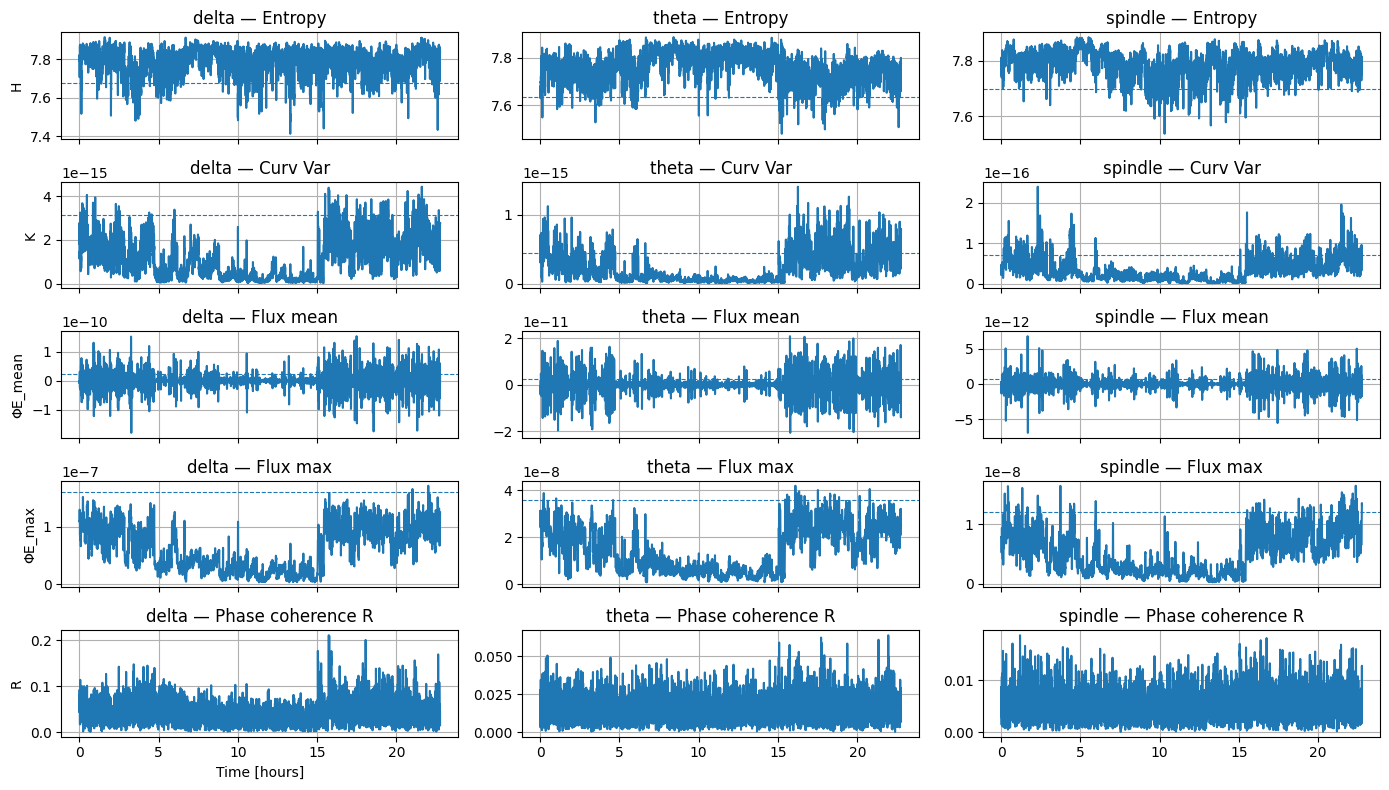

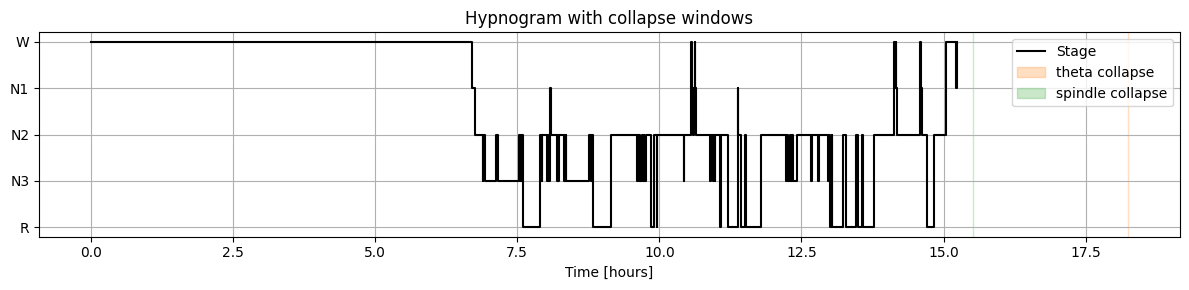

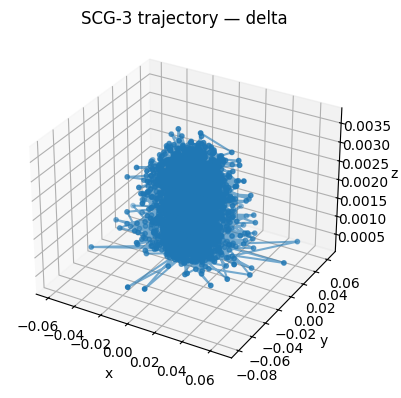

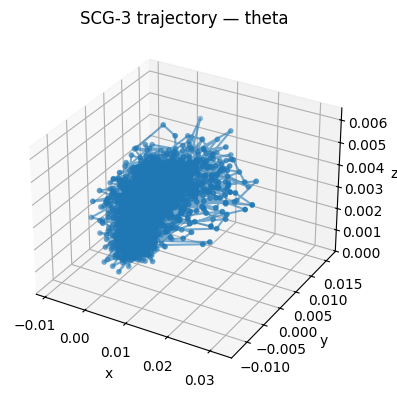

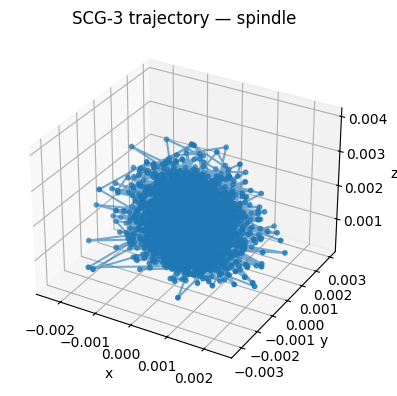

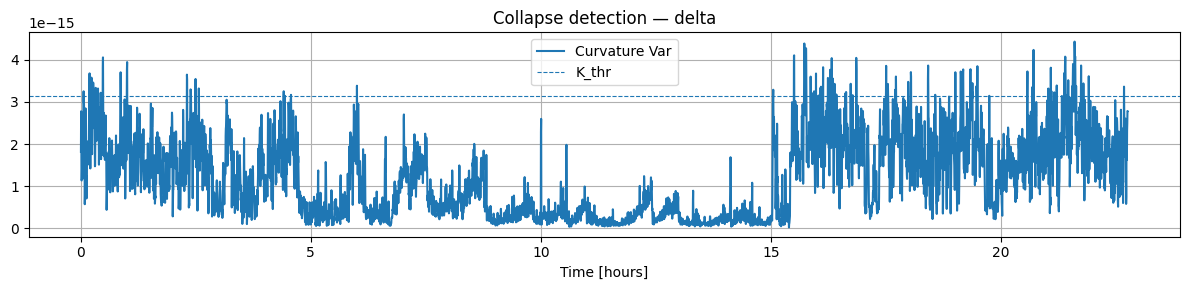

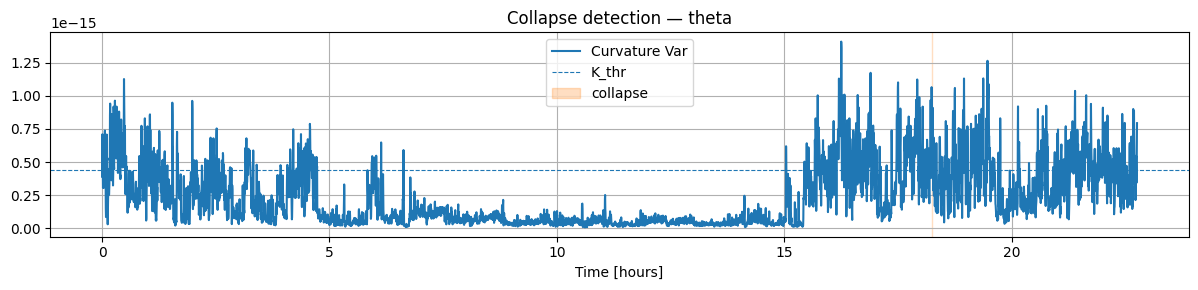

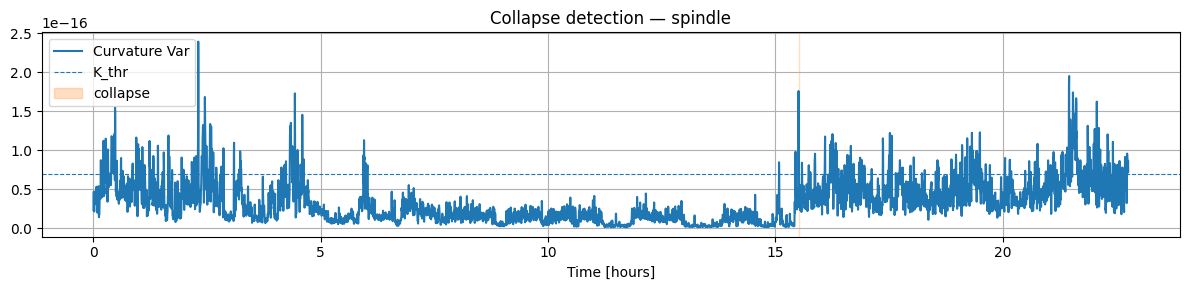

In [6]:
result, annot, sfreq = analyze_subject_multiband(data_dir, "SC4091E0", "SC4091EC", channel="EEG Fpz-Cz")
# print('metadata for SC4091E0 SSC4091EC')
# extract_metadata(result, annot, sfreq)


## Subject SC4551F0 (Cassette)
- **Transitions:** 111.  
- **REM time:** ~3.5 min.  
- **Collapse:** multiple micro-events.  
- **Delta:** collapse at ~18.7 h.  
- **Theta:** collapse at ~22.2 h.  
- **Spindle:** early collapse at ~5.5 h.  
- **Fingerprint:** all three bands collapse, but at different times; **no convergence**.

Subject SC4551F0 SC4551FC Invariants (spindle global):
  Entropy (H): 15.662
  Curvature variance: 3.326e-17
  Energy flux mean: -9.627e-17
  Energy flux max:  1.553e-08

Collapse windows per band:
Band         Start (h)     Mid (h)     End (h)   Dur (min)
----------------------------------------------------------
delta            18.68       18.68       18.68         0.0
theta            22.19       22.19       22.19         0.0
spindle           5.47        5.47        5.48         0.5


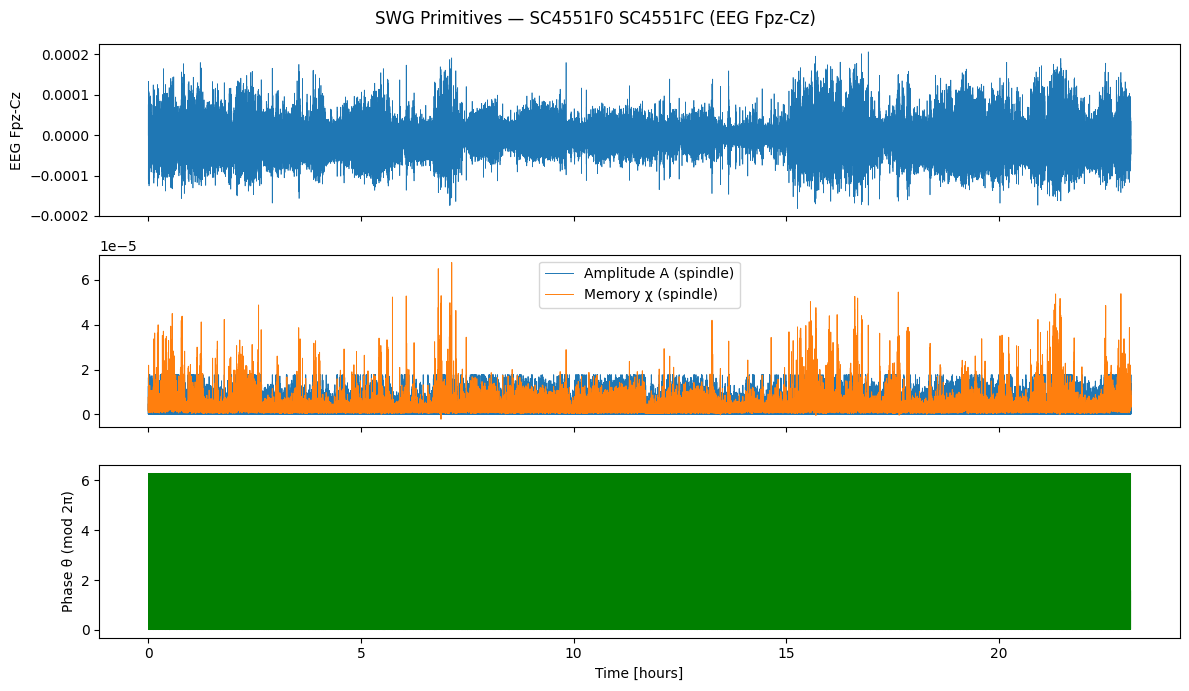

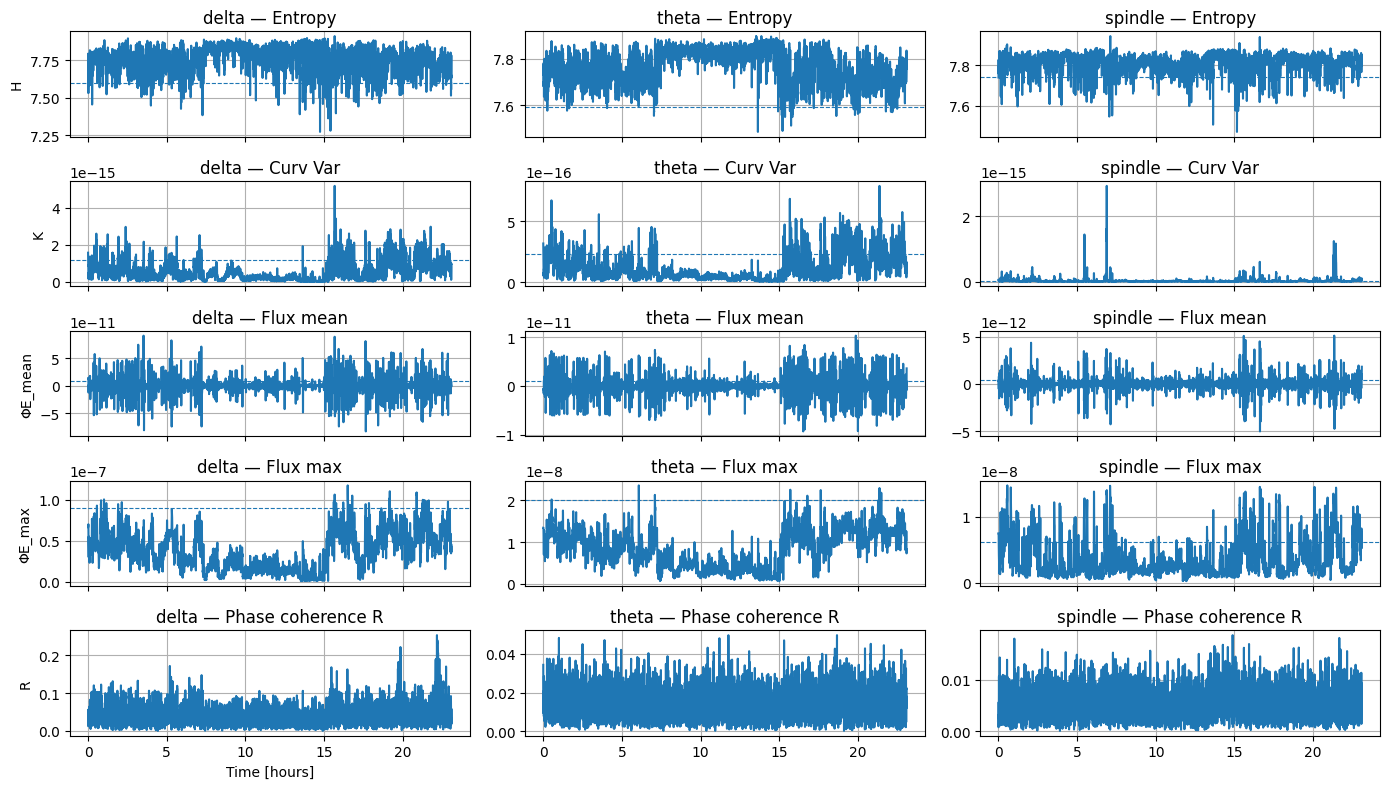

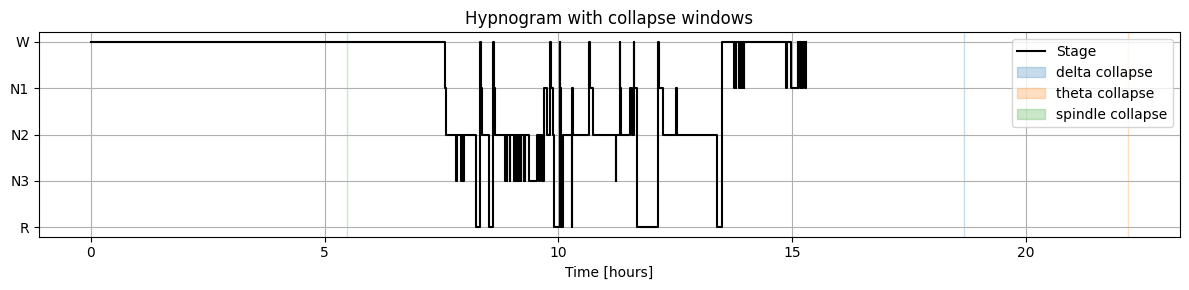

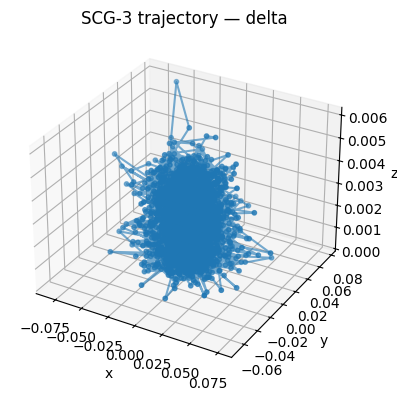

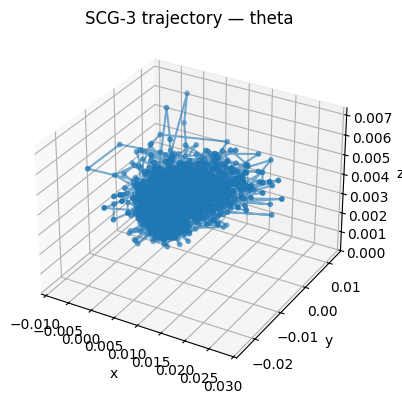

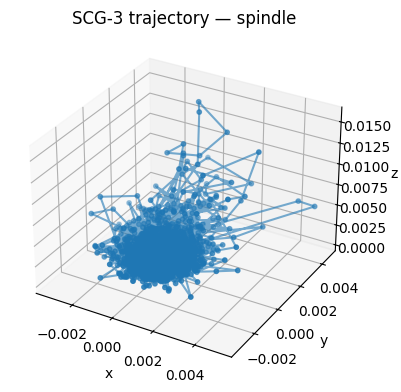

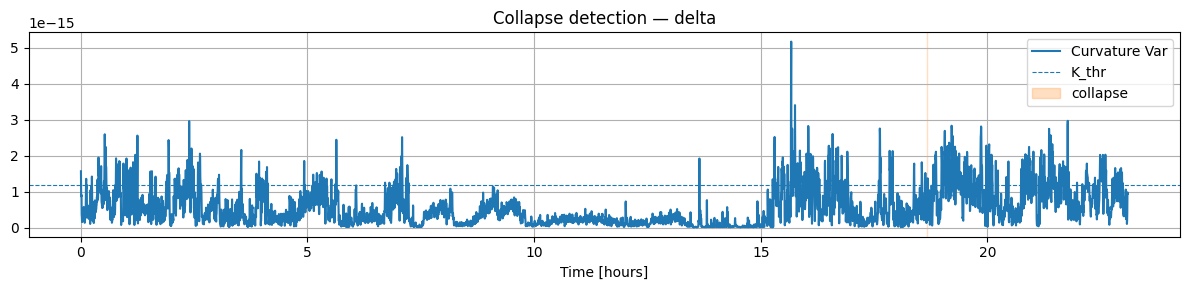

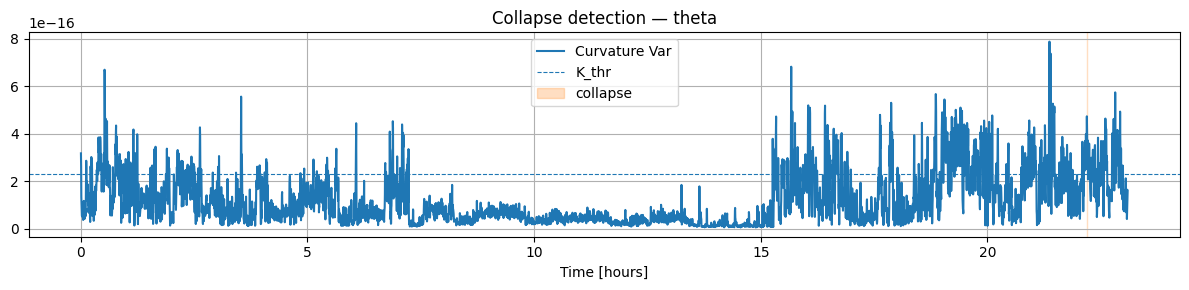

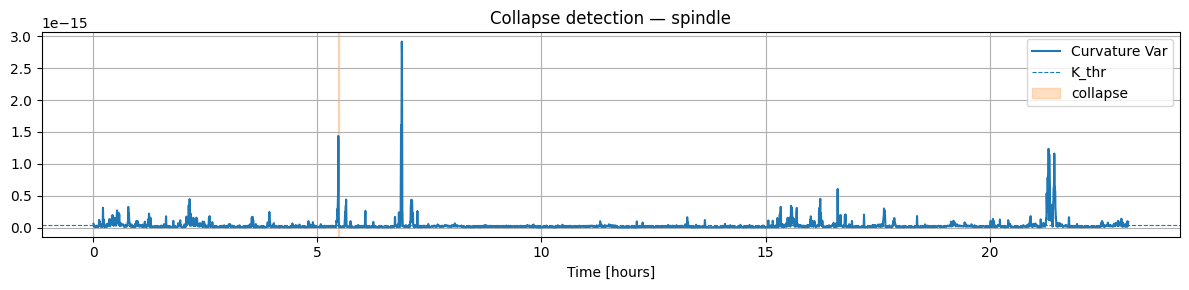

In [7]:
result, annot, sfreq = analyze_subject_multiband(data_dir, "SC4551F0", "SC4551FC", channel="EEG Fpz-Cz")
# print('metadata for SC4551F0 SC4551FC')
# extract_metadata(result, annot, sfreq)

## Subject SC4672G0 (Cassette)
- **Transitions:** 115.  
- **REM time:** ~2.5 min.  
- **Collapse:** **only spindle collapse** (~17.5 h).  
- **Delta:** stable throughout.  
- **Theta:** no collapse detected.  
- **Spindle:** collapse at 17.5 h (0.5 min).  
- **Fingerprint:** selective — delta/theta stable, spindle weak.

Subject SC4672G0 SC4672GV Invariants (spindle global):
  Entropy (H): 15.604
  Curvature variance: 1.259e-17
  Energy flux mean: 8.860e-18
  Energy flux max:  7.538e-09

Collapse windows per band:
Band         Start (h)     Mid (h)     End (h)   Dur (min)
----------------------------------------------------------
delta               --          --          --          --
theta               --          --          --          --
spindle          17.51       17.51       17.52         0.5


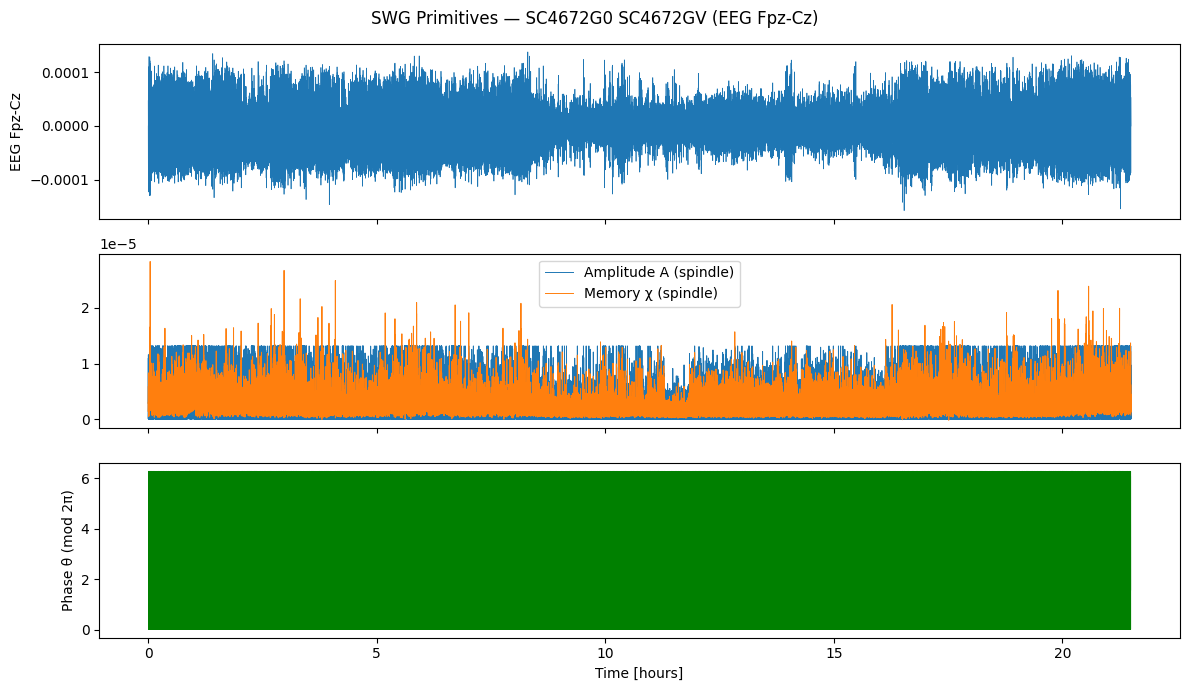

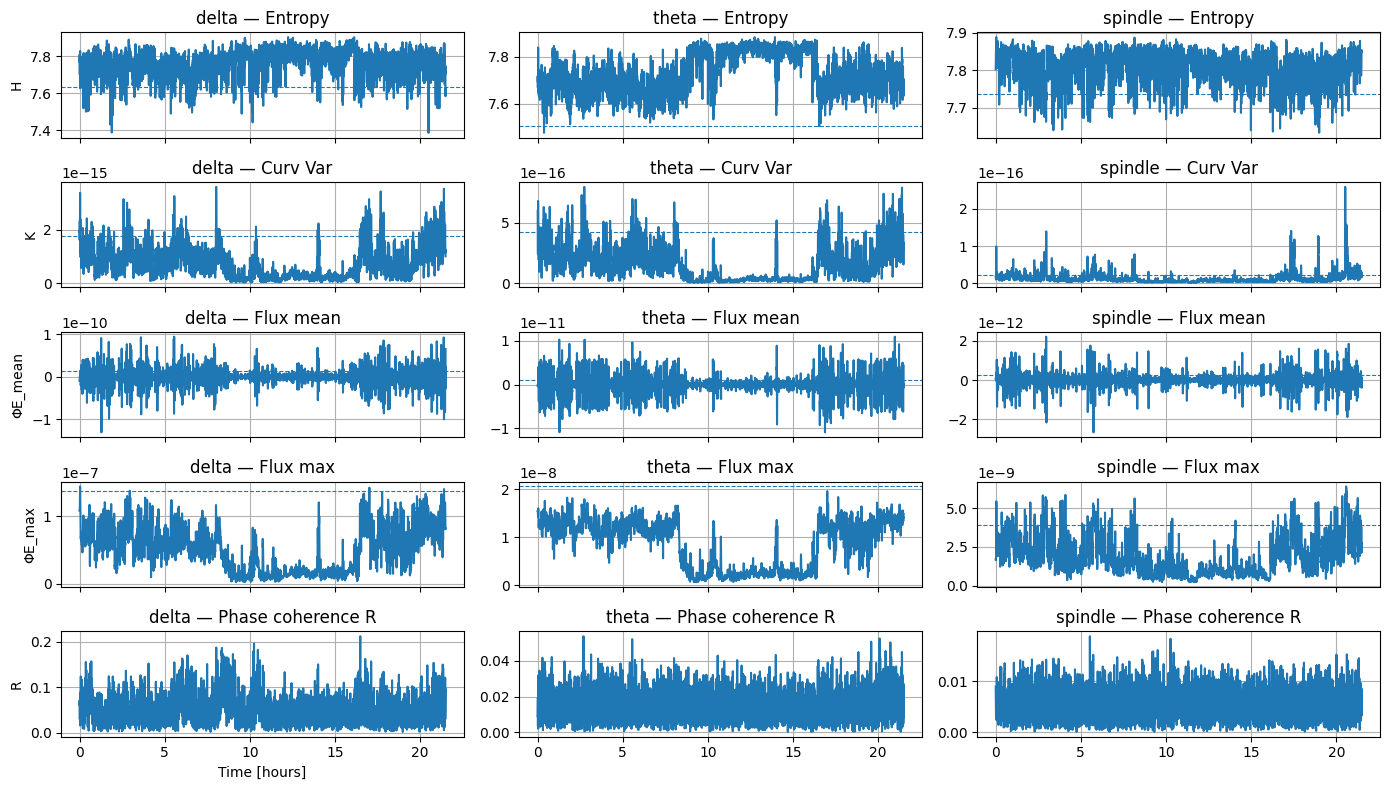

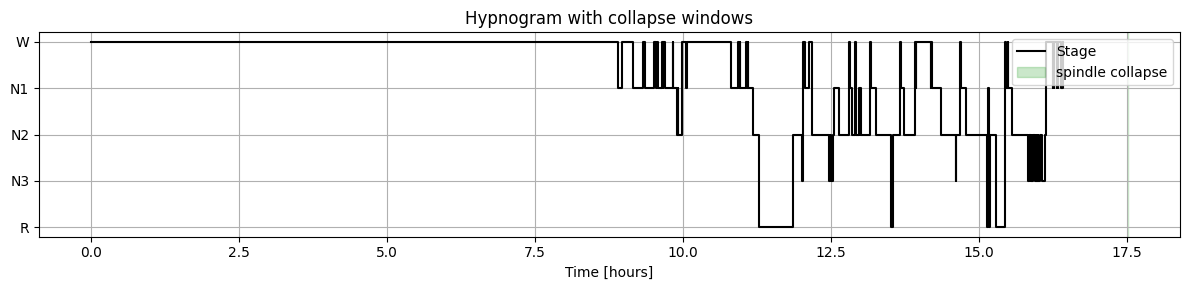

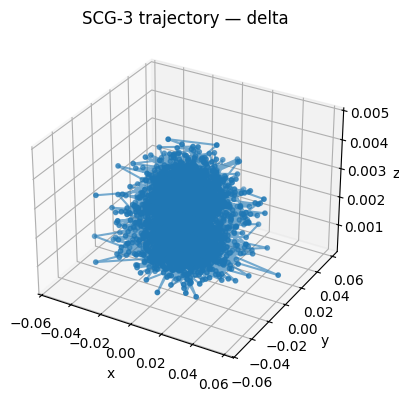

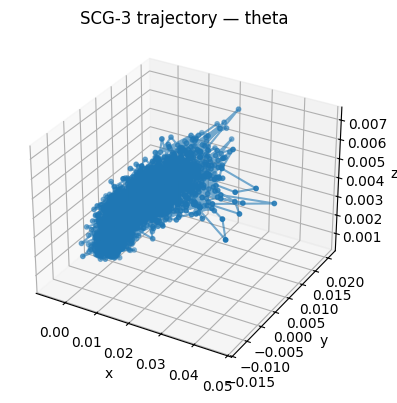

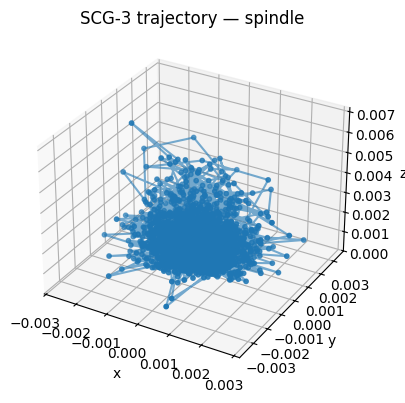

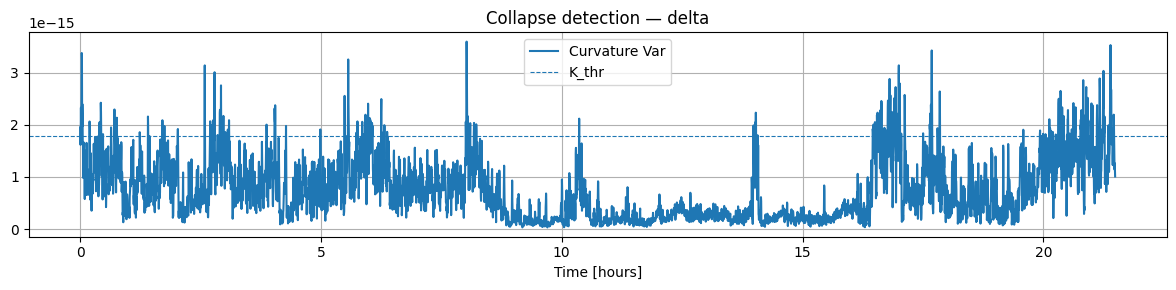

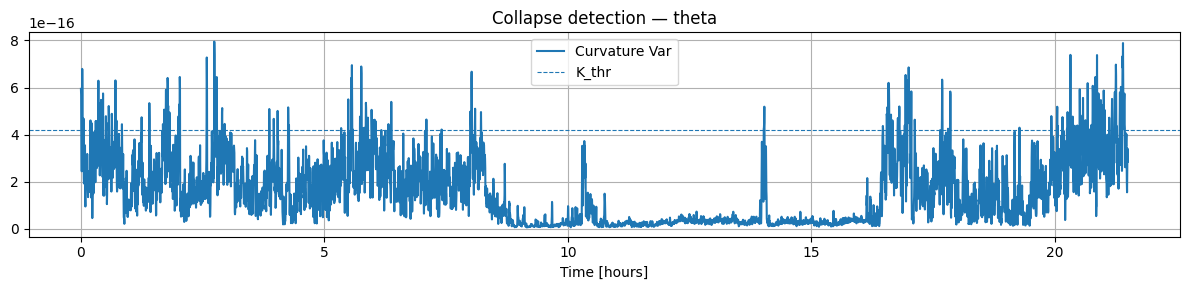

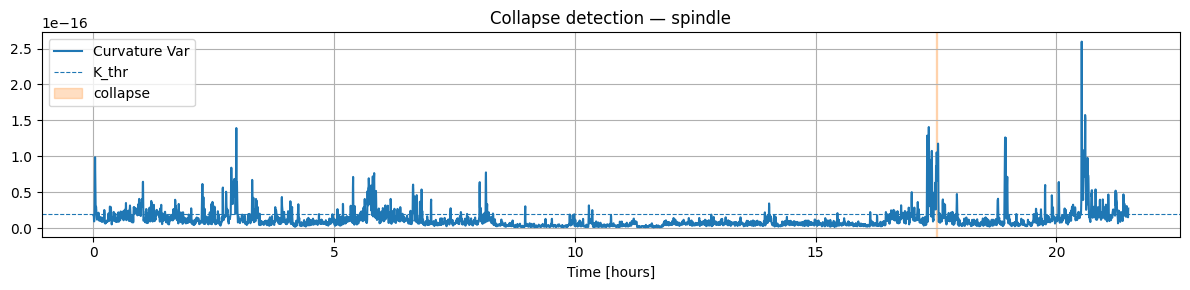

In [8]:
result, annot, sfreq = analyze_subject_multiband(data_dir, "SC4672G0", "SC4672GV", channel="EEG Fpz-Cz")
# print('metadata for SC4672G0 SC4672GV')
# extract_metadata(result, annot, sfreq)

# Cross-Subject Comparison

| Subject   | Dataset    | Transitions | REM (min) | Delta collapse | Theta collapse | Spindle collapse | Fingerprint type | Notes |
|-----------|------------|-------------|-----------|----------------|----------------|------------------|------------------|-------|
| ST7011J0  | Telemetry  | 137         | 4.5       | 9.10 h (0.2)   | 9.05–9.10 h (3.2) | 9.10 h (0.2)    | **Terminal convergence** | All bands collapse together at final REM→Wake. |
| ST7201J0  | Telemetry  | 231         | 5.0       | 1.67 h (0.2)   | 2.92 h (0.2)   | 6.46 h (0.0)     | **Fragmented**          | Multiple early-night micro-collapses, no global event. |
| ST7152J0  | Telemetry  | 167         | 9.0       | 8.70 h (0.0)   | 8.70 h (0.2)   | —                | **Hybrid**              | Delta/theta collapse late in REM, spindle coherence preserved. |
| SC4091E0  | Cassette   | 148         | 8.5       | —              | 18.25 h (0.0)  | 15.51 h (0.2)    | **Micro-events**        | Delta highly stable; isolated theta/spindle collapses. |
| SC4551F0  | Cassette   | 111         | 3.5       | 18.68 h (0.0)  | 22.19 h (0.0)  | 5.47 h (0.5)     | **Distributed**         | All three bands collapse at different times, no convergence. |
| SC4672G0  | Cassette   | 115         | 2.5       | —              | —              | 17.51 h (0.5)    | **Selective**           | Only spindle collapse; delta/theta remain stable. |

### Group patterns
- **Telemetry subjects**:  
  - Tend toward **terminal convergence** (ST7011J0, ST7152J0) or **fragmented early collapses** (ST7201J0).  
- **Cassette subjects**:  
  - Show **micro-collapse events** in theta/spindle, with delta usually stable.  
  - Collapses spread across the night without global convergence.


# Why This Matters

SWG/SCG analysis reveals **deterministic coherence dynamics** in sleep EEG:

- **Not just stage scoring:** Collapse ≠ amplitude peaks. It is defined by invariant thresholds (entropy drop, curvature spike, flux surge).  
- **Band-specific geometry:**  
  - Delta (N3) → stable spirals.  
  - Theta (REM) → scattered excursions.  
  - Spindle (N2) → compact loops.  
  Each rhythm has its own collapse dynamics.  
- **Cross-dataset generalization:**  
  - **Telemetry (overnight PSG):** global terminal collapses or fragmented early-night collapses.  
  - **Cassette (shorter/variable):** localized micro-events, stable delta.  
- **Subject fingerprints:** Each individual shows a distinct SCG trajectory and collapse pattern — terminal, fragmented, hybrid, distributed, or selective.  
- **Clinical potential:** Collapse fingerprints may serve as **biomarkers** of sleep quality, fragmentation, or pathology.  
- **Cross-domain resonance:** Collapse dynamics mirror those in **black holes** (curvature blowup), **proteins** (misfolding), and **AI systems** (hallucination onset).

**In short:** SWG/SCG predicts what physiology expects (REM instability, N3 stability) *and* uncovers dataset- and subject-specific coherence geometries invisible to conventional scoring.
